In [238]:
import pyomo.environ as pyo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from operator import mul
from pyomo.environ import *

In [239]:
from Parameters import * 
db_connection = mysql.connector.connect(
    host="localhost",
    user="root",
    passwd="root", # change password
    auth_plugin='mysql_native_password'
)
db_cursor = db_connection.cursor(buffered=True)
db_cursor.execute("USE earthquake")

##### Parameters

In [240]:
def set_victim_parameters(start_time, end_time):
    K = Parameters.num_of_immediate(db_cursor, start_time, end_time) #number of victims with condition 3 (immediate)
    L = Parameters.num_of_delayed(db_cursor, start_time, end_time) #number of victims condition 2 (delay)
    victim_dict = Parameters.victim_dict(db_cursor, start_time, end_time) #all victims
    immediate_v_id_list, delayed_v_id_list = Parameters.victim_id_lists(victim_dict) #immediate and delayed victim id's
    neighbourhood_list, hospital_list, distances = Parameters.distances(victim_dict, hospital_dict)
    y_immediate_list, y_delayed_list = Parameters.y_lists(victim_dict) #age
    t_immediate_list, t_delayed_list = Parameters.t_lists(victim_dict) #time elapsed
    neighbourhood_immediate_list, neighbourhood_delayed_list = Parameters.neighbourhood_lists(victim_dict)
    return K, L, victim_dict, immediate_v_id_list, delayed_v_id_list, neighbourhood_list, hospital_list,\
            distances, y_immediate_list, y_delayed_list, t_immediate_list, t_delayed_list, \
            neighbourhood_immediate_list, neighbourhood_delayed_list

##### Variables

In [241]:
def set_variables(immediate_v_id_list, delayed_v_id_list):
    #x: Binary variable. victim i to hospital j
    #THE ONLY WAY I COULD FIND TO HAVE 2 INDEXED VARIABLES - DONT QUESTION IT TOO MUCH
    m.I = pyo.RangeSet(0, len(immediate_v_id_list)-1)
    m.D = pyo.RangeSet(0, len(delayed_v_id_list)-1)
    m.J = pyo.RangeSet(0, len(hospital_id_list)-1)

    m.K = np.ndarray(shape=(len(immediate_v_id_list),len(hospital_id_list)))
    m.L = np.ndarray(shape=(len(delayed_v_id_list),len(hospital_id_list)))

    def IJ_rule(m):
        return [(i,j) for i in range(len(m.I)) for j in range(len(m.K[i]))]

    def DJ_rule(m):
        return [(d,j) for d in range(len(m.D)) for j in range(len(m.L[d]))]

    m.immediate = Set(within=m.I*m.J, initialize=IJ_rule)
    m.immediate_v = Var(m.immediate, within = Binary) #for immediate
    m.delayed = Set(within=m.D*m.J, initialize=DJ_rule)
    m.delayed_v = Var(m.delayed, within = Binary) #for delayed

##### Objective Function 


In [242]:
def obj_rule(m):
    immediate = 0
    for k in range(K):
        for j in range(H):
            neighbourhood_index = neighbourhood_list.index(neighbourhood_immediate_list[k])
            immediate += c_1*t_immediate_list[k]*y_immediate_list[k]*distances[neighbourhood_index][j]*m.immediate_v[k,j]
            
    delayed = 0
    for l in range(L):
        for j in range(H):
            neighbourhood_index = neighbourhood_list.index(neighbourhood_delayed_list[l])
            delayed += c_2*t_delayed_list[l]*y_delayed_list[l]*distances[neighbourhood_index][j]*m.delayed_v[l,j]
            
    penalty_immediate = K - sum(m.immediate_v[k,j] for k in range(K) for j in range(H))
    
    penalty_delayed = L - sum(m.delayed_v[l,j] for l in range(L) for j in range(H))
    
    return immediate + delayed + E*(c_1*penalty_immediate + c_2*penalty_delayed)

##### Constraints

In [243]:
def bed_capacity_constraint(m, j):
    return sum(m.immediate_v[k, j] for k in range(K)) + sum(m.delayed_v[l, j] for l in range(L)) <= leftover_bed_capacity_list[j]

In [244]:
def allocation_constraint_immediate(m, k):
    return sum(m.immediate_v[k, j] for j in range(H) ) <= 1 

def allocation_constraint_delayed(m, l):
    return sum(m.delayed_v[l, j] for j in range(H) ) <= 1

In [245]:
def update_bed_capacity(bed_capacity_list):
    for j in range(H):
        assigned_immediate = sum(pyo.value(m.immediate_v[k,j]) for k in range(K))
        assigned_delayed = sum(pyo.value(m.delayed_v[l,j]) for l in range(L))    
        bed_capacity_list[j] -= assigned_immediate + assigned_delayed

In [246]:
def solve():
    solver = SolverFactory('glpk')
    solution = solver.solve(m)
    unassigned_immediate = K - sum(pyo.value(m.immediate_v[k,j]) for k in range(K) for j in range(H))
    assigned_immediate = sum(pyo.value(m.immediate_v[k,j]) for k in range(K) for j in range(H))
    unassigned_delayed = L - sum(pyo.value(m.delayed_v[l,j]) for l in range(L) for j in range(H))
    assigned_delayed = sum(pyo.value(m.delayed_v[l,j]) for l in range(L) for j in range(H))
    objective_value = pyo.value(m.objective)
    update_bed_capacity(leftover_bed_capacity_list)
    return unassigned_immediate, assigned_immediate, unassigned_delayed, assigned_delayed, \
            objective_value
    

In [247]:
def solve_model_periodically(start_time, end_time, bed_capacity_list):    
    global K, L, victim_dict, immediate_v_id_list, delayed_v_id_list, neighbourhood_list, hospital_list, distances,\
    y_immediate_list, y_delayed_list, t_immediate_list, t_delayed_list, neighbourhood_immediate_list,\
    neighbourhood_delayed_list
    K, L, victim_dict, immediate_v_id_list, delayed_v_id_list, neighbourhood_list, hospital_list, distances,\
    y_immediate_list, y_delayed_list, t_immediate_list, t_delayed_list, neighbourhood_immediate_list,\
    neighbourhood_delayed_list = set_victim_parameters(start_time, end_time)
    set_variables(immediate_v_id_list, delayed_v_id_list)
    print("victims",K," ",L)
    print("current_capacity",bed_capacity_list)
    #more parameters
    global E, c_1, c_2
    c_1 = 1.02 #condition: immediate
    c_2 = 1 #condition: delayed
    #epsilon value is calculated as the average of the coefficients of the x_ij's in order to make the penalty meaningful
    E = (c_2*sum(map(mul, y_immediate_list, t_immediate_list)) + c_1*sum(map(mul, y_delayed_list, t_delayed_list)))/(c_1+c_2)
    m.objective = pyo.Objective(rule=obj_rule, sense=pyo.minimize)
    m.bed_capacity_constraint = pyo.Constraint(range(H), rule = bed_capacity_constraint)
    m.allocation_constraint_immediate = pyo.Constraint(range(K), rule = allocation_constraint_immediate)
    m.allocation_constraint_delayed = pyo.Constraint(range(L), rule = allocation_constraint_delayed)
    return solve()

In [248]:
#only queried once
H = Parameters.num_of_hospitals(db_cursor) #operational hospitals
hospital_dict = Parameters.hospital_dict(db_cursor) 
hospital_id_list = Parameters.hospital_id_lists(hospital_dict)
leftover_bed_capacity_list = Parameters.hospital_bed_capacity_lists(hospital_dict)
records = {}
def record_of_allocation(time_interval):
    global leftover_bed_capacity_list
    global m
    i = 0
    while sum(leftover_bed_capacity_list):
        start_time = i*time_interval
        end_time = (i+1)*time_interval
        m = pyo.ConcreteModel()
        unassigned_immediate, assigned_immediate, unassigned_delayed, assigned_delayed, \
        objective_value = solve_model_periodically(start_time, end_time, leftover_bed_capacity_list)
        
        records[i] = {"Unassigned immediate": unassigned_immediate, "Assigned immediate": assigned_immediate, \
                    "Unassigned delayed": unassigned_delayed, "Assigned delayed": assigned_delayed, \
                    "Objective value": objective_value}
        i += 1
    return records

In [249]:
time_interval = 10
result = record_of_allocation(time_interval)
total_immediate = 0
total_delayed = 0
for key,value in result.items():
    print("Iteration:", key, "\tInfo:", value)
    total_immediate += value['Assigned immediate']
    total_delayed += value['Assigned delayed']
print(total_immediate, total_delayed)

victims 17   55
current_capacity [103, 30, 70, 40, 40, 40, 400, 120]
victims 15   71
current_capacity [85.0, 30.0, 70.0, 7.0, 27.0, 32.0, 400.0, 120.0]
victims 16   110
current_capacity [45.0, 30.0, 70.0, 0.0, 6.0, 14.0, 400.0, 120.0]
victims 22   106
current_capacity [0.0, 27.0, 12.0, 0.0, 0.0, 0.0, 400.0, 120.0]
victims 20   130
current_capacity [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 316.0, 115.0]
victims 29   142
current_capacity [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 171.0, 110.0]
victims 31   154
current_capacity [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 104.0]
Iteration: 0 	Info: {'Unassigned immediate': 0.0, 'Assigned immediate': 17.0, 'Unassigned delayed': 0.0, 'Assigned delayed': 55.0, 'Objective value': 7562.823457904154}
Iteration: 1 	Info: {'Unassigned immediate': 0.0, 'Assigned immediate': 15.0, 'Unassigned delayed': 0.0, 'Assigned delayed': 71.0, 'Objective value': 28294.438300295107}
Iteration: 2 	Info: {'Unassigned immediate': 0.0, 'Assigned immediate': 16.0, 'Unassigned delayed': 0.0, 'Assi

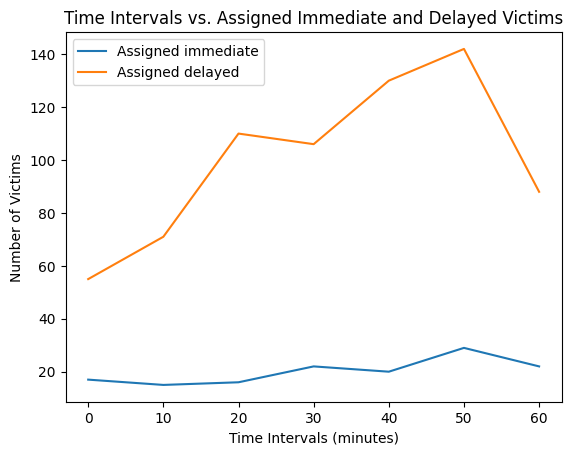

In [250]:
# Plotting the results
x = list(result.keys())
x_time = [i*time_interval for i in x]
y_immediate = [result[key]['Assigned immediate'] for key in x]
y_delayed = [result[key]['Assigned delayed'] for key in x]
plt.plot(x_time, y_immediate, label = "Assigned immediate")
plt.plot(x_time, y_delayed, label = "Assigned delayed")
plt.xlabel('Time Intervals (minutes)')
plt.ylabel('Number of Victims')
plt.title('Time Intervals vs. Assigned Immediate and Delayed Victims')
plt.legend()
plt.show()
